In [24]:
%%bash
echo $PYTHONPATH

/Users/wamess/PycharmProjects/windTurbineExp


In [25]:


import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
from sklearn import preprocessing

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
scaler = preprocessing.StandardScaler()
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 299)


In [27]:
from sklearn.model_selection import train_test_split

epochs = 3000
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
# for train, test in kf.split(data):
#     ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
#     loss = nn.MSELoss()
#     # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
#     optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
#     train_labels = labels[train]
#     test_labels = labels[test]
#     X_train, X_test = data[train][train_labels==0], data[test]
#     for epoch in range(epochs):
#         print(f"\n=====epoch {epoch}/{epochs}=====")
#         train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
#                           batch_size=30000)
#
#     res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
#     i += 1
#     if i == 1:
#         break

X_train = X_train[y_train == 0]

ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=30000)

res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)


=====epoch 0/3000=====
loss: 0.777249  [21850/21850]

=====epoch 1/3000=====
loss: 0.775496  [21850/21850]

=====epoch 2/3000=====
loss: 0.773954  [21850/21850]

=====epoch 3/3000=====
loss: 0.772251  [21850/21850]

=====epoch 4/3000=====
loss: 0.769916  [21850/21850]

=====epoch 5/3000=====
loss: 0.766358  [21850/21850]

=====epoch 6/3000=====
loss: 0.760870  [21850/21850]

=====epoch 7/3000=====
loss: 0.752546  [21850/21850]

=====epoch 8/3000=====
loss: 0.740337  [21850/21850]

=====epoch 9/3000=====
loss: 0.722980  [21850/21850]

=====epoch 10/3000=====
loss: 0.699271  [21850/21850]

=====epoch 11/3000=====
loss: 0.669038  [21850/21850]

=====epoch 12/3000=====
loss: 0.634836  [21850/21850]

=====epoch 13/3000=====
loss: 0.605829  [21850/21850]

=====epoch 14/3000=====
loss: 0.597505  [21850/21850]

=====epoch 15/3000=====
loss: 0.584830  [21850/21850]

=====epoch 16/3000=====
loss: 0.552576  [21850/21850]

=====epoch 17/3000=====
loss: 0.519294  [21850/21850]

=====epoch 18/3000=

0.9683046683046683


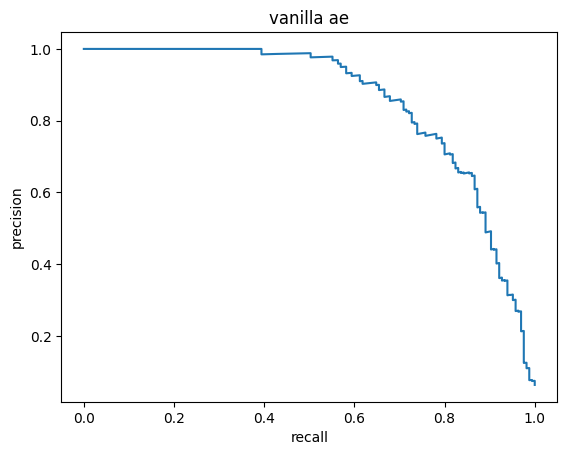

In [28]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in y_test]
point_size = [0.1 if label == 0 else 10 for label in y_test]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

precision, recall, threshold = metrics.precision_recall_curve(y_test, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))
# print(metrics.auc(precision, recall))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("vanilla ae")
plt.show()

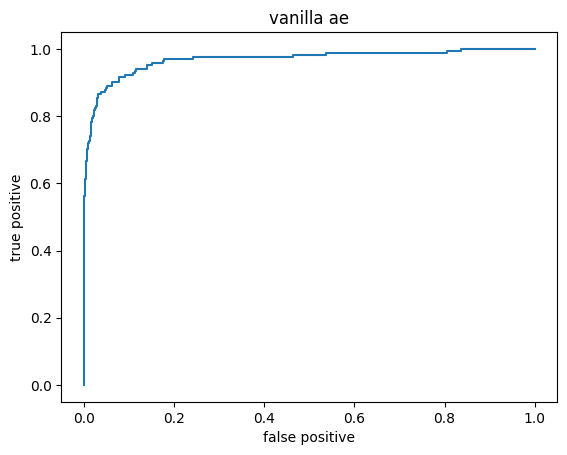

In [29]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("vanilla ae")
plt.show()

In [69]:
from omnixai.data.tabular import Tabular
from omnixai.explainers.tabular import CounterfactualExplainer
from torch import nn

import json

import plotly.io as pio
pio.renderers.default = "png"

threshold = 65

possibility = 1 / (1 + np.exp(-(res-threshold)))

# print(np.sum(possibility > 0.5))
# print(y_test.sum(), "/", y_test.size)

# print(threshold)
# def predict_fun(x):
#     distance = train_model.autoencoder_test(x, x, ae_model, x.size[0])
#     return 1 / (1 + np.exp(-(distance-threshold)))

class PredictFunc(nn.Module):
    def __init__(self, the_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ae_model = the_model
        self.threshold = 65

    def forward(self, x):
        distance = train_model.autoencoder_test(x, x, self.ae_model, len(x))
        res = 1 / (1 + np.exp(-(distance-self.threshold)))
        return torch.tensor([[n] for n in res])


predict_fun = PredictFunc(ae_model)

feature_names = data_load.load_turbine_data_without_time(DATA_PATH).columns.tolist()

tabular_data = Tabular(
    X_train,
    feature_columns=feature_names
)

explainer = CounterfactualExplainer(
    training_data = tabular_data,
    predict_function=predict_fun
)

explanations = explainer.explain(X_test[y_test==1][:1])
explanations.ipython_plot()
exp = explanations.get_explanations()
# with open("out.json", 'w') as file:
#     file.write(json.dumps(exp))
print(exp)
# exp[0].to_csv("out.csv",sep=',',index=False,header=True)
exp = exp[0]['query'].drop('label', axis=1)
# print(exp)

[{'query':    Wind speed (m/s)  Wind speed, Standard deviation (m/s)   
0         -0.819468                             -0.857528  \

   Wind speed, Minimum (m/s)  Wind speed, Maximum (m/s)  Long Term Wind (m/s)   
0                  -0.842016                  -0.866318             -0.922377  \

   Wind speed Sensor 1 (m/s)  Wind speed Sensor 1, Standard deviation (m/s)   
0                  -0.829518                                      -0.803118  \

   Wind speed Sensor 1, Minimum (m/s)  Wind speed Sensor 1, Maximum (m/s)   
0                           -0.979754                           -0.869912  \

   Wind speed Sensor 2 (m/s)  ...  Tower Acceleration X, Min (mm/ss)   
0                  -0.835707  ...                          -1.144359  \

   Tower Acceleration X, Max (mm/ss)  Tower Acceleration Y, Min (mm/ss)   
0                          -0.766298                          -1.036457  \

   Tower Acceleration Y, Max (mm/ss)  Drive train acceleration, Max (mm/ss)   
0             

/Users/wamess/PycharmProjects/windTurbineExp/train_model.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [73]:
compare = pd.concat([pd.DataFrame(X_test[:1], columns=feature_names), exp])
# scaler.inverse_transform(exp[0]['query'].drop('label', axis=1))
compare = scaler.inverse_transform(compare)
# compare.
# compare = np.append(compare, np.subtract(compare[0], compare[1]))
exp_res = pd.DataFrame(compare, columns=feature_names)
# exp_res.diff()
exp_res

,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",Wind speed Sensor 2 (m/s),...,Tower Acceleration y (mm/ss),"Tower Acceleration X, Min (mm/ss)","Tower Acceleration X, Max (mm/ss)","Tower Acceleration Y, Min (mm/ss)","Tower Acceleration Y, Max (mm/ss)","Drive train acceleration, Max (mm/ss)","Drive train acceleration, Min (mm/ss)","Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)"
0,5.369435,1.151672,3.270950,7.93835,6.2,5.459405,0.995340,3.573907,7.654414,5.297921,...,18.497095,8.526660,119.887222,3.776069,51.856026,5.138272,5.138272,9.400211e-12,27.994328,11.253816
1,3.652997,0.444771,2.413875,4.48950,6.2,3.598744,0.434978,2.308612,4.421394,3.590180,...,9.404751,1.791121,62.381744,1.244375,30.813587,3.135488,3.135488,9.400211e-12,15.341227,6.754881
